In [1]:
### Set CUDA device
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '7'

In [2]:

from typing import (
    Dict, 
    Union, 
    List
)
import numpy as np
import pandas as pd
import torch
from torch import Tensor, nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import sys
from omegaconf import OmegaConf
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict
from torchvision.transforms import GaussianBlur
from torchmetrics.functional.classification import dice
from sklearn.covariance import LedoitWolf
from torchmetrics.classification import BinaryPrecisionRecallCurve

## Augmentations
from batchgenerators.transforms.noise_transforms import augment_gaussian_blur


sys.path.append('../')
from data_utils import get_eval_data
from model.unet import get_unet
from utils import  epoch_average, UMapGenerator
from model.mahalanobis_adatper import (
    get_pooling_mahalanobis_detector, 
    get_batchnorm_mahalanobis_detector
)
from model.wrapper import PoolingMahalanobisWrapper, BatchNormMahalanobisWrapper

# from losses import (
#     DiceScoreCalgary, 
#     DiceScoreMMS
# )

nnUNet_raw_data_base is not defined and nnU-Net can only be used on data for which preprocessed files are already present on your system. nnU-Net cannot be used for experiment planning and preprocessing like this. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up properly.
RESULTS_FOLDER is not defined and nnU-Net cannot be used for training or inference. If this is not intended behavior, please read documentation/setting_up_paths.md for information on how to set this up.


In [3]:
### Load basic config
cfg = OmegaConf.load('../configs/basic_config_venusberg.yaml')
OmegaConf.update(cfg, 'run.iteration', 0)

In [4]:
### Set dataset, either brain or heart
DATA_KEY = 'heart'
OmegaConf.update(cfg, 'run.data_key', DATA_KEY)


### get model
# available models:
#     - default-8
#     - default-16
#     - monai-8-4-4
#     - monai-16-4-4
#     - monai-16-4-8
#     - monai-32-4-4
#     - monai-64-4-4
#     - swinunetr


unet_name = 'default-8'
postfix = '' # '_no-blurring'
args = unet_name.split('-')
cfg.unet[DATA_KEY].pre = unet_name + postfix
cfg.unet[DATA_KEY].arch = args[0]
cfg.unet[DATA_KEY].n_filters_init = int(args[1])

if args[0] == 'monai':
    cfg.unet[DATA_KEY].depth = int(args[2])
    cfg.unet[DATA_KEY].num_res_units = int(args[3])


unet, state_dict = get_unet(
    cfg,
    update_cfg_with_swivels=False,
    return_state_dict=True)
unet.load_state_dict(state_dict)
_ = unet.cuda()

In [5]:
# Set debug mode for only a small fraction of the datasets. Speeds up this cell by alot
cfg.debug = False

# update config with default values
OmegaConf.update(
    cfg, 
    'eval',
    OmegaConf.load('../configs/eval/unet_config.yaml')
)

# Wether and how you want to subset in case of Brain data. WARNING:
# After subsetting the eval below will not work with surface
# Dice anymore, because volumes are fragmented. 
APPLY_SUBSETTING = True
OmegaConf.update(cfg, 'eval.data.subset.apply', APPLY_SUBSETTING)
subset_params = {
    'n_cases': 256,  # selects at most so many cases
    'fraction': 0.1, # selects from the 10% worst cases w.r.t to a model
}
OmegaConf.update(
    cfg, 
    'eval.data.subset.params', 
    OmegaConf.create(subset_params)
)

if cfg.eval.data.subset.apply:
    subset_dict = OmegaConf.to_container(
        cfg.eval.data.subset.params, 
        resolve=True, 
        throw_on_missing=True
    )
    subset_dict['unet'] = unet
else:
    subset_dict = None

### select the datasets within the domain
# get training data
cfg.eval.data.training = True
# get validation data
cfg.eval.data.validation = False
# get testing data
# Options for Brain are any subset of [1, 2, 3, 4, 5] or 'all' 
# Options for Heart are any subset of ['A', 'B', 'C', 'D'] or 'all'
cfg.eval.data.testing =  ['A'] #


data = get_eval_data(
    train_set=cfg.eval.data.training,
    val_set=cfg.eval.data.validation,
    test_sets=cfg.eval.data.testing,    
    cfg=cfg,
    subset_dict=subset_dict
)

print(f'\nAvailable datasets are: {list(data.keys())}')

loading dataset
loading all case properties
loading dataset
loading all case properties

Available datasets are: ['train', 'A']


In [6]:
dataloader = DataLoader(
    data['train'],
    batch_size=32,
    shuffle=False,
    num_workers=4,
    drop_last=False,
)

In [7]:
def get_precision_recall_iterated_mahalanobis(
    unet: nn.Module,
    iid_loader: DataLoader,
    dataset: Dataset, 
    net_out: str,
    swivels: List[str],
    umap: str,
    n_taus: Union[str, int] = 'auto',
    device=['cuda:0', 'cpu']
):
    
    
    batch_size = 32

    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        drop_last=True
    )

    umap_generator = UMapGenerator(
        method=umap,
        net_out=net_out,
    ).to(device[0])

    
    errmaps = []

    for i, swivel in enumerate(swivels):

        # init mahalanobis detector
        model = get_pooling_mahalanobis_detector(
            swivels=[swivel],
            unet=unet,
            pool='none',
            sigma_algorithm='diagonal',
            fit='raw',
            iid_data=iid_loader, 
            transform=True,
            dist_fn='squared_mahalanobis',
            device='cuda:0',
            lr=5e-4
        )
        model.eval()
        # collect umaps
        umaps_new = []
        for _, batch in enumerate(dataloader):

            input_ = batch['input'].to(device[0])
            gt = batch['target'].to(device[0])
            gt[gt == -1] = 0
            model.set_transform(False)
            output_original = model(input_)
            model.set_transform(True)
            output_transformed = model(input_)
            if i == 0:
                if net_out == 'brain':
                    segmap = (torch.sigmoid(output_original) > 0.5) * 1
                    errmap = (gt != segmap).float()
                elif net_out == 'heart':
                    segmap = torch.argmax(output_original, dim=1, keepdims=True)
                    errmap = (gt != segmap).float()
                errmaps.append(errmap.cpu())

                
            umaps_new.append(
                umap_generator(
                    torch.cat([output_original, output_transformed], dim=0), 
                    batch_size=batch_size
                ).cpu()
            )
        
        umaps_new = torch.cat(umaps_new, dim=0).flatten() * 10000

        if i == 0:
            umaps = umaps_new.clone()
        else:
            # umaps = torch.stack([umaps, umaps_new], dim=0).max(0).values
            umaps += umaps_new
        
    umaps = (umaps - umaps.min()) / (umaps.max() - umaps.min())
    errmaps = torch.cat(errmaps, dim=0).flatten().to(torch.uint8)
    # in case of manual threshold selection
    if n_taus != 'auto':
        # taus = np.quantile(umaps, torch.linspace(0, 1, n_taus)**(1/16)).tolist()
        taus = np.quantile(umaps, torch.linspace(0, 1, n_taus)).tolist()
    elif n_taus == 'auto':
        taus = None

    # TODO: Change to torcheval once its stable :)
    # bprc = torcheval.metrics.BinaryPrecisionRecallCurve()
    bprc = BinaryPrecisionRecallCurve(thresholds = taus).to(device[1])
    pr = bprc(umaps.to(device[1]), errmaps.to(device[1]))
    if device[1] != 'cpu':
        pr = tuple(map(lambda x: x.cpu(), pr))

    pr_auc = auc(pr[1], pr[0])
    # subset precision/recall to 100 points for plotting
    # we find indices along the x axis (recall) such that they
    # have roughly equal distance to each other and select the 
    # corresponding y values (precision)
    p, r, _= pr  
    # find indices for sorting in recall
    indices = np.argsort(r)
    # sort precision and recall similarly
    r_sorted, p_sorted = (r[indices], p[indices])
    # select target values for recall
    target_values = np.linspace(r_sorted[0], r_sorted[-1], 100)
    # find best matches in sorted recall, that are smaller or equal to the target values
    subset_indices = np.abs(r_sorted[None, :] - target_values[:, None]).argmin(axis=1)
    # select precision and recall at the best matches
    r_sampled, p_sampled = (
        r_sorted[subset_indices], 
        p_sorted[subset_indices]
    )

    return p_sampled, r_sampled, pr_auc, p, r

Processing train data


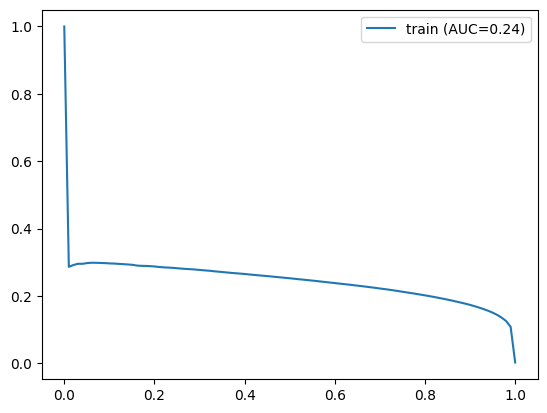

Processing A data


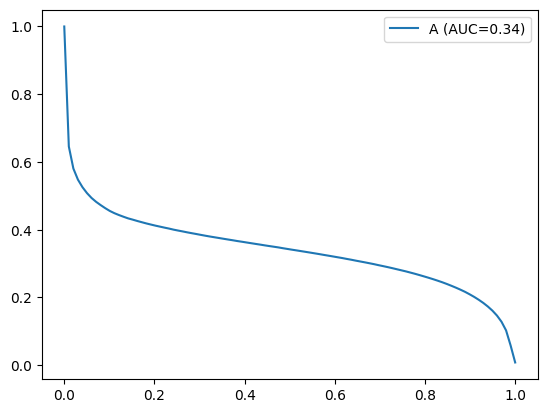

Processing B data


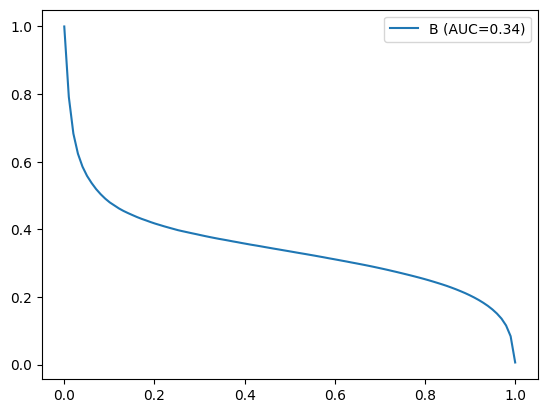

Processing C data


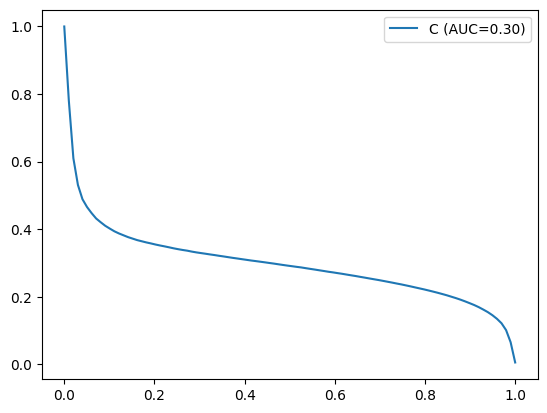

Processing D data


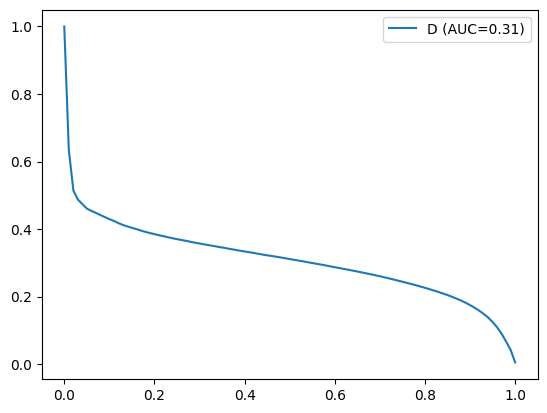

In [8]:
swivels = [layer[0] for layer in unet.named_modules() if 'bn' in layer[0]]

for domain in data.keys():
    print(f'Processing {domain} data')
    p_sampled, r_sampled, pr_auc, p, r = get_precision_recall_iterated_mahalanobis(
        unet=unet,
        iid_loader=dataloader,
        dataset=data[domain],
        net_out='heart',
        swivels=swivels,
        n_taus='auto',
        umap='diff_grad',
        device=['cuda:0', 'cpu']
    )

    plt.plot(r_sampled, p_sampled, label=f'{domain} (AUC={pr_auc:.2f})')
    plt.legend()
    plt.show()

In [ ]:
pr_auc

PR AUC: 0.3290720582008362


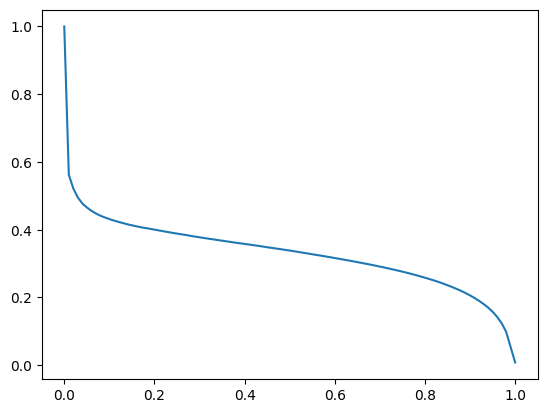

In [33]:
print(f'PR AUC: {pr_auc}')
plt.plot(r_sampled, p_sampled, label='Precision-Recall Curve')

PR AUC: 0.2833046615123749


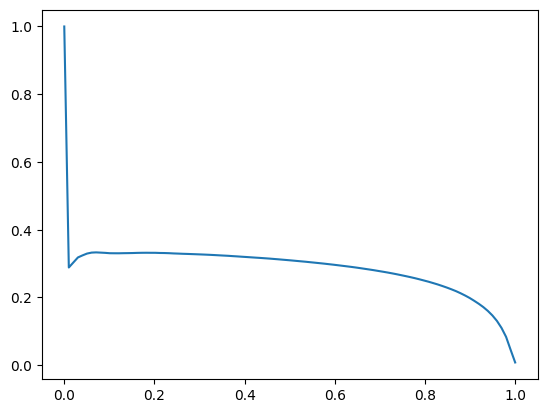

In [30]:
print(f'PR AUC: {pr_auc}')
plt.plot(r_sampled, p_sampled, label='Precision-Recall Curve')

In [122]:
def get_precision_recall_mahalanobis(
    model: nn.Module, 
    dataset: Dataset, 
    net_out: str,
    swivels: List[str],
    umap: str,
    n_taus: Union[str, int] = 'auto',
    device=['cuda:0', 'cpu']
):
    model.eval()
    
    batch_size = 32

    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        drop_last=True
    )

    umap_generator = UMapGenerator(
        method=umap,
        net_out=net_out,
    ).to(device[0])

    umaps   = []
    errmaps = []

    for _, batch in enumerate(dataloader):

        input_ = batch['input'].to(device[0])
        gt = batch['target'].to(device[0])
        gt[gt == -1] = 0
        model.set_transform(False)
        output_original = model(input_)
        model.set_transform(True)

        output_transformed = model(input_)

        if net_out == 'brain':
            segmap = (torch.sigmoid(output_original) > 0.5) * 1
            errmap = (gt != segmap).float()
        elif net_out == 'heart':
            segmap = torch.argmax(output_original, dim=1, keepdims=True)
            errmap = (gt != segmap).float()
        umaps.append(
            umap_generator(
                torch.cat([output_original, output_transformed], dim=0), 
                batch_size=batch_size
            ).cpu()
        )
        errmaps.append(errmap.cpu())

    umaps = torch.cat(umaps, dim=0).flatten() * 10000
    # print(umaps.min(), umaps.max())
    umaps = (umaps - umaps.min()) / (umaps.max() - umaps.min())
    errmaps = torch.cat(errmaps, dim=0).flatten().to(torch.uint8)
    # in case of manual threshold selection
    if n_taus != 'auto':
        # taus = np.quantile(umaps, torch.linspace(0, 1, n_taus)**(1/16)).tolist()
        taus = np.quantile(umaps, torch.linspace(0, 1, n_taus)).tolist()
    elif n_taus == 'auto':
        taus = None

    # TODO: Change to torcheval once its stable :)
    # bprc = torcheval.metrics.BinaryPrecisionRecallCurve()
    bprc = BinaryPrecisionRecallCurve(thresholds = taus).to(device[1])
    pr = bprc(umaps.to(device[1]), errmaps.to(device[1]))
    if device[1] != 'cpu':
        pr = tuple(map(lambda x: x.cpu(), pr))

    pr_auc = auc(pr[1], pr[0])
    # subset precision/recall to 100 points for plotting
    # we find indices along the x axis (recall) such that they
    # have roughly equal distance to each other and select the 
    # corresponding y values (precision)
    p, r, _= pr  
    # find indices for sorting in recall
    indices = np.argsort(r)
    # sort precision and recall similarly
    r_sorted, p_sorted = (r[indices], p[indices])
    # select target values for recall
    target_values = np.linspace(r_sorted[0], r_sorted[-1], 100)
    # find best matches in sorted recall, that are smaller or equal to the target values
    subset_indices = np.abs(r_sorted[None, :] - target_values[:, None]).argmin(axis=1)
    # select precision and recall at the best matches
    r_sampled, p_sampled = (
        r_sorted[subset_indices], 
        p_sorted[subset_indices]
    )

    return p_sampled, r_sampled, pr_auc, p, r

In [89]:
def filter_names_by_group(names, groups):
    # Create a dictionary to hold the names categorized by group
    grouped_names = {}

    # Loop over each name in the list
    for name in names:
        # Split the name on the dot and take the first part as the group
        group_key = name.split('.')[0]

        # If the group_key is one of the requested groups, add the name to the corresponding list in the dictionary
        if group_key in groups:
            if group_key not in grouped_names:
                grouped_names[group_key] = []
            grouped_names[group_key].append(name)

    # Prepare the result list by aggregating all names from requested groups
    result_names = []
    for group in groups:
        if group in grouped_names:
            result_names.extend(grouped_names[group])

    return result_names


['init_path.2.conv_path.0.bn', 'init_path.2.conv_path.1.bn', 'init_path.3.conv_path.0.bn', 'init_path.3.conv_path.1.bn', 'init_path.4.conv_path.0.bn', 'init_path.4.conv_path.1.bn', 'down1.3.conv_path.0.bn', 'down1.3.conv_path.1.bn', 'down1.4.conv_path.0.bn', 'down1.4.conv_path.1.bn', 'out_path.0.conv_path.0.bn', 'out_path.0.conv_path.1.bn', 'out_path.1.bn']


In [123]:
swivels = [layer[0] for layer in unet.named_modules() if 'bn' in layer[0]]
# swivels = [layer[0] for layer in unet.named_modules()]

swivel_selections = []
# groups = ['up3']
# swivels = filter_names_by_group(swivels, groups)
# for group in groups:
#     swivel_selections.append(filter_names_by_group(swivels, [group]))
# swivel_selections = [
#     ['up3.0.conv_path.0.bn'], 
#     ['up1.0.conv_path.0.bn'],
#     ['up2.0.conv_path.0.bn'],
#     ['out_path.0.conv_path.0.bn']
# ]

# swivels=[
#     'down2.4.conv_path.1.bn',
#     'down2.5.conv_path.1.bn',
#     'up3.0.conv_path.0.bn',
#     'up1.1.conv_path.0.bn',
#     'down1.5.conv_path.1.bn',
#     'down3.4.conv_path.1.bn',
# ]
# for swivel_selection in swivel_selections:
mahalanobis_detector = get_pooling_mahalanobis_detector(
    swivels=swivels,
    unet=unet,
    pool='none',
    sigma_algorithm='diagonal',
    fit='raw',
    iid_data=dataloader,
    transform=True,
    dist_fn='squared_mahalanobis',
    device='cuda:0',
    lr=5e-4
)
for domain in ['D']:

    p_sampled, r_sampled, pr_auc, umaps = get_precision_recall_mahalanobis(
        model=mahalanobis_detector,
        dataset=data[domain],
        net_out=DATA_KEY,
        umap='diff_grad',
        n_taus='auto',
        device=['cuda:0', 'cpu']
    )
    print(domain, pr_auc)
    # plt.plot(r_sampled, p_sampled)
    # plt.show()

D 0.19872000813484192


In [7]:
swivels = [layer[0] for layer in unet.named_modules() if 'bn' in layer[0]]


mahalanobis_detector = get_pooling_mahalanobis_detector(
    swivels=['down2.3.conv_path.1.bn'],
    unet=unet,
    pool='none',
    sigma_algorithm='diagonal',
    fit='raw',
    iid_data=dataloader,
    transform=True,
    dist_fn='squared_mahalanobis',
    device='cuda:0',
    lr=5e-4
)

tensor(8257) torch.Size([4194304])


In [9]:
mahalanobis_detector.adapters[0].training_representations.shape

torch.Size([1518, 1, 131072])

In [10]:
131072 / 32

4096.0